# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [ ]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

## Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [ ]:

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


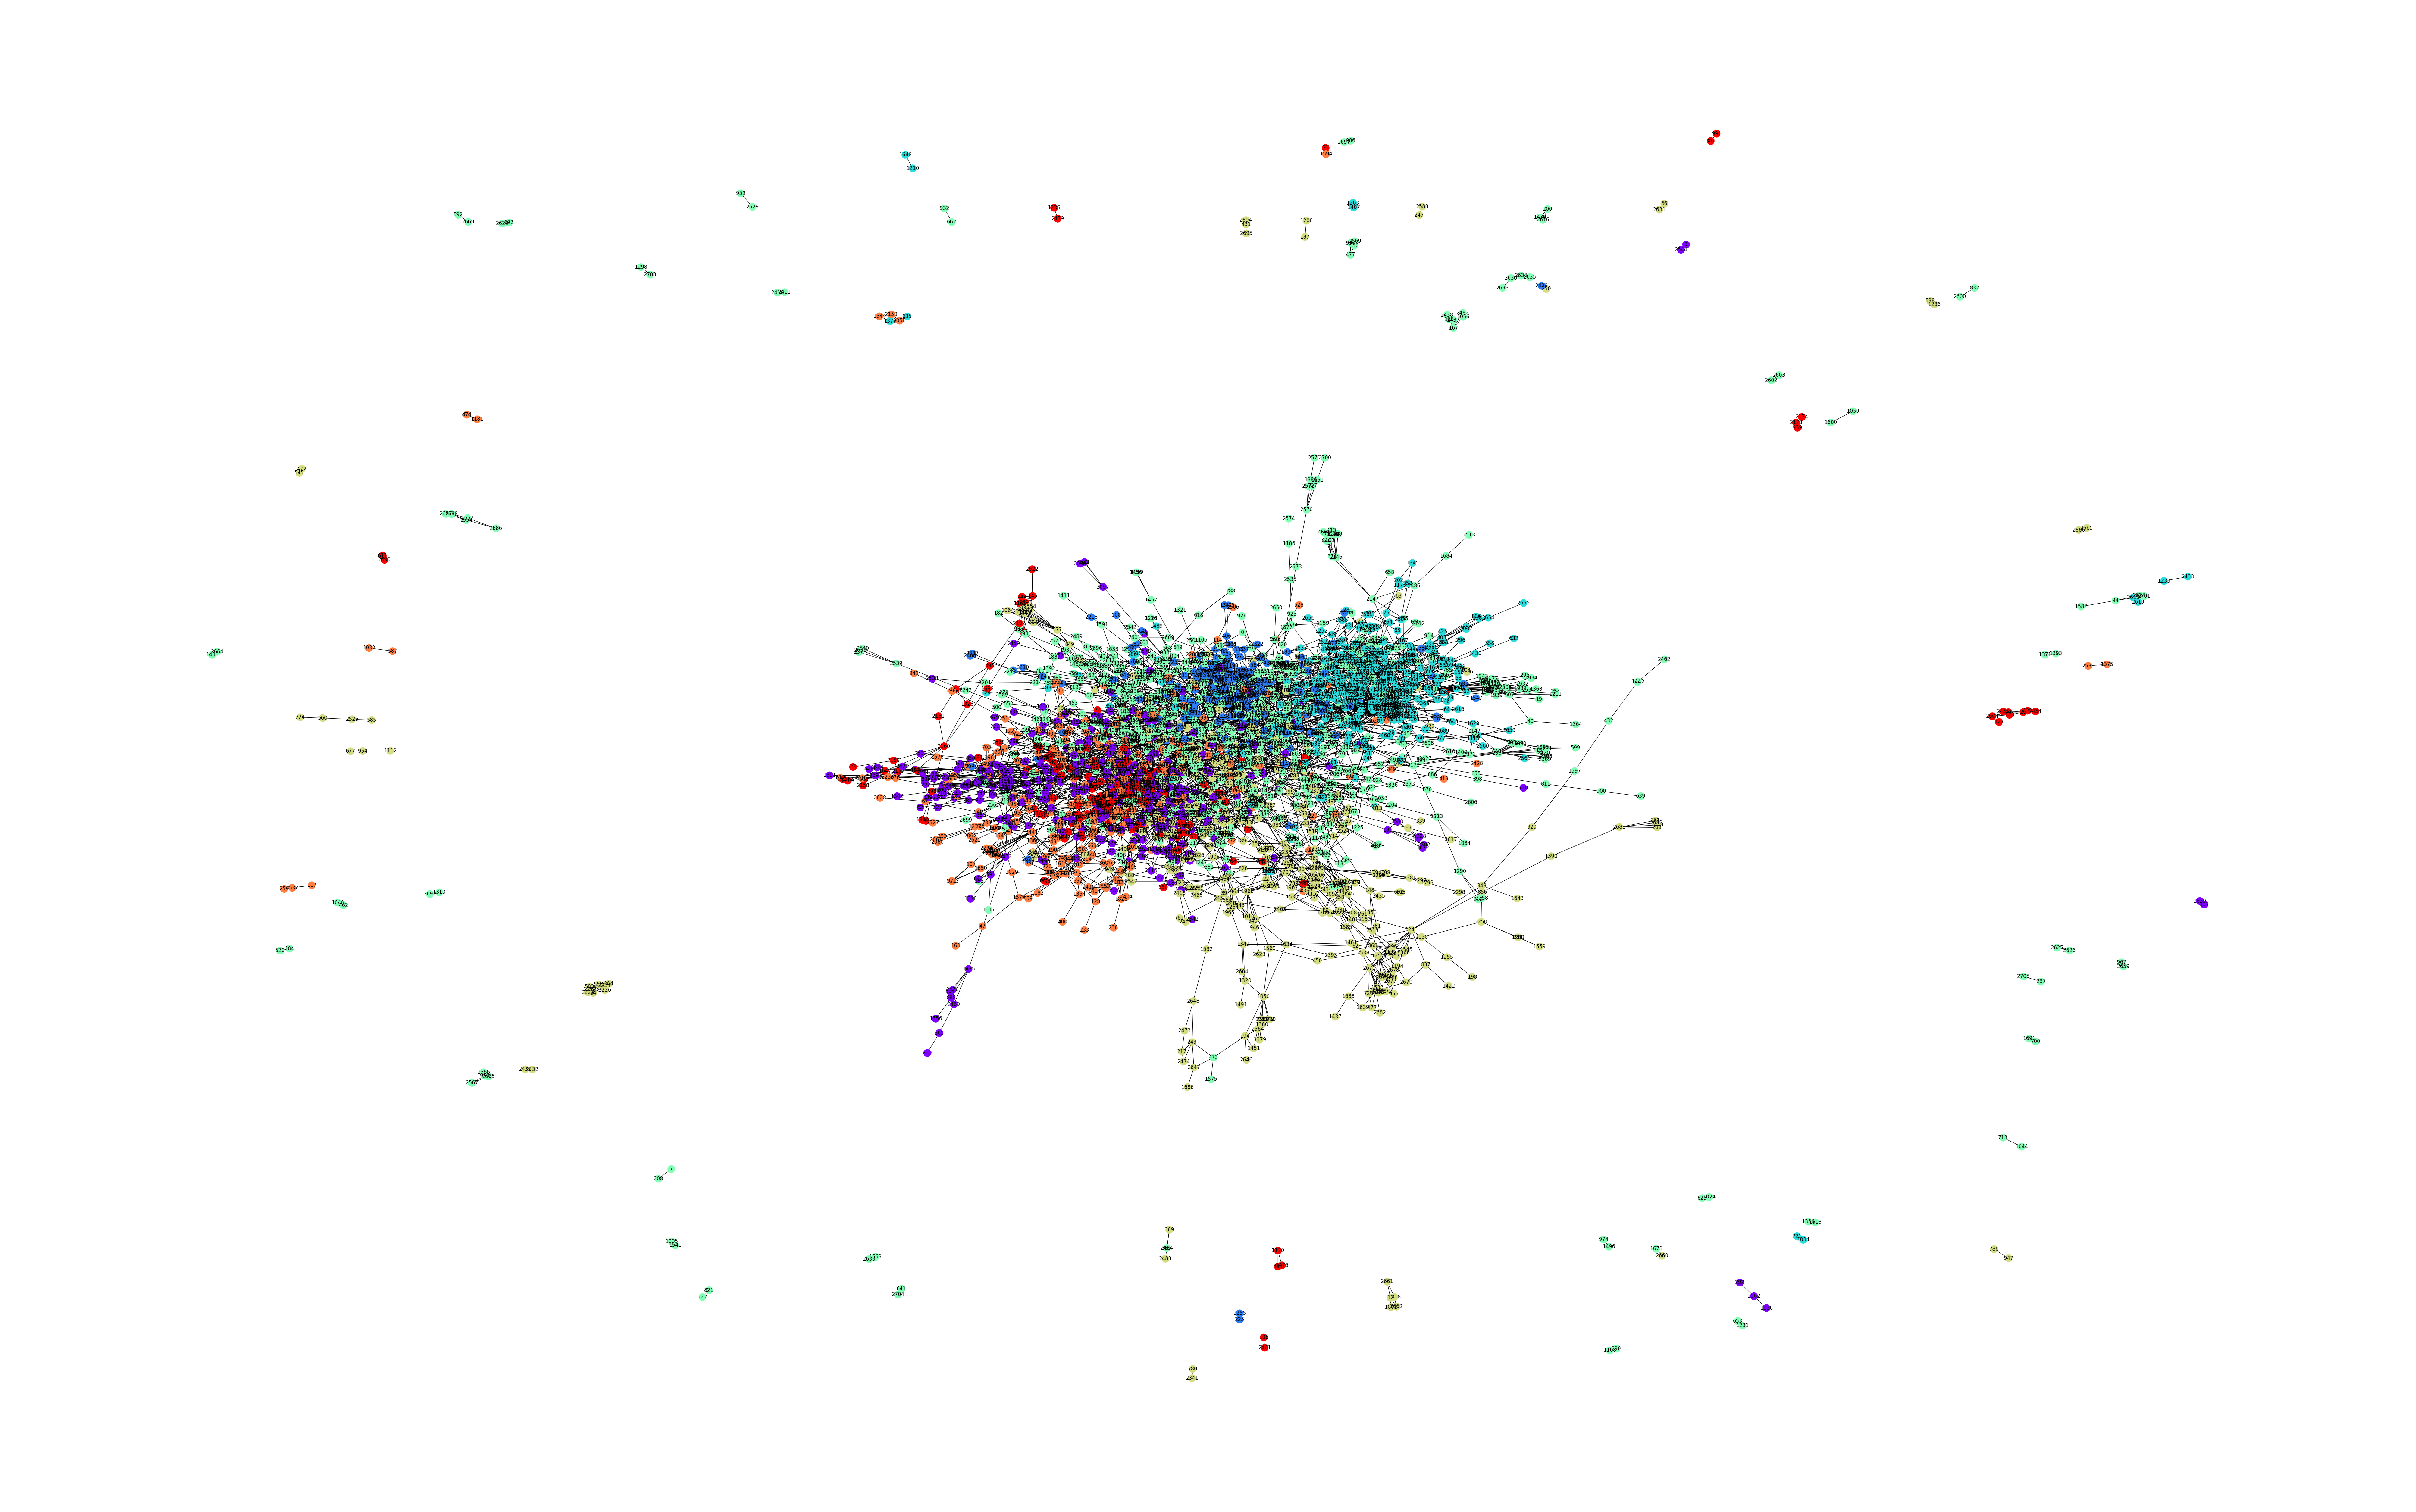

In [ ]:
# Conversion des données au format NetworkX
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edge_index = data.edge_index.cpu().numpy()
edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)

# Visualisation du graphe avec différenciation des classes
color_map = [data.y[node].item() for node in G.nodes]

plt.figure(figsize=(80, 50))
pos = nx.spring_layout(G)  # Vous pouvez choisir un autre algorithme de disposition si vous le souhaitez
nx.draw(G, pos, node_color=color_map, cmap=plt.cm.rainbow, with_labels=True)
plt.show()

In [ ]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.
---



Importing Libraries :

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

Construisons notre modèle avec deux couches GAT sous forme d'une classe

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8 # nombre de sorties de la première couche
        self.in_head = 8 # nombre de head du multi-head attention
        self.out_head = 1 # nombre de sorties dans la dernière couche


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6) # première couche qui donne en sortie 8 outputs
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6) # deuxième couche

    def forward(self, data): # cette méthode nous fait la prpagation en avant de notre modèle
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
model = GAT() # Initiation du modèle


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) # la fonction d'optimisation, nous avons choisi la fonction adam

model.train() # Maintenant on commence l'entraînement du modèle avec 1000 epochs
for epoch in range(1000):
    model.train()
    optimizer.zero_grad() # Pour rénitialiser le gradient dans chaque itération
    out = model(data) # le output du modèle pour calculer l'erreur
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9650, grad_fn=<NllLossBackward0>)
tensor(0.2450, grad_fn=<NllLossBackward0>)
tensor(0.2780, grad_fn=<NllLossBackward0>)
tensor(0.3241, grad_fn=<NllLossBackward0>)
tensor(0.3441, grad_fn=<NllLossBackward0>)


In [ ]:
model.eval() # Evaluation du modèle
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7940
